#### Requirements

In [ ]:
# !pip install datasets[audio] torchaudio_augmentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 17.8 MB/s eta 0:00:00
  Created wheel for julius: filename=julius-0.2.7-py3

## Dataset

In [ ]:
import torchaudio
from datasets import load_dataset
from torch.utils.data import Dataset


class GTZAN(Dataset):

    def __init__(self, split="train"):
        self.dataset = load_dataset("marsyas/gtzan", split=split)
        self.labels = ['blues', 'classical', 'country', 'disco', 'hiphop',
                       'jazz', 'metal', 'pop', 'reggae', 'rock']

        self.label2idx = {label: idx for idx, label in enumerate(self.labels)}
        self.n_classes = len(self.labels)

    def __getitem__(self, idx):
        file_path = self.dataset[idx]['file']
        audio, sr = torchaudio.load(file_path)
        label = self.label2idx[self.labels[self.dataset[idx]['genre']]]

        return audio, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
"""Wrapper for Torch Dataset class to enable contrastive training
"""
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torchaudio_augmentations import Compose
from typing import Tuple, List


class ContrastiveDataset(Dataset):
    def __init__(self, dataset: Dataset, input_shape: List[int], transform: Compose):
        self.dataset = dataset
        self.transform = transform
        self.input_shape = input_shape
        self.ignore_idx = []

    def __getitem__(self, idx) -> Tuple[Tensor, Tensor]:
        if idx in self.ignore_idx:
            return self[idx + 1]

        audio, label = self.dataset[idx]

        if audio.shape[1] < self.input_shape[1]:
            self.ignore_idx.append(idx)
            return self[idx + 1]

        if self.transform:
            audio = self.transform(audio)
        return audio, label

    def __len__(self) -> int:
        return len(self.dataset)

    def concat_clip(self, n: int, audio_length: float) -> Tensor:
        audio, _ = self.dataset[n]
        batch = torch.split(audio, audio_length, dim=1)
        batch = torch.cat(batch[:-1])
        batch = batch.unsqueeze(dim=1)

        if self.transform:
            batch = self.transform(batch)

        return batch

In [ ]:
import os
from torchaudio_augmentations import(ComposeMany, RandomResizedCrop)

def get_dataset(dataset):
    train_transform = [RandomResizedCrop(n_samples=59049)]
    num_augmented_samples = 1
    if dataset == "gtzan":
        d = GTZAN()
        contrastive_dataset = ContrastiveDataset(
        d,
        input_shape=(1, 59049),
        transform=ComposeMany(train_transform, num_augmented_samples)
    )
    else:
        raise NotImplementedError("Dataset not implemented")
    return contrastive_dataset

#### Dataset tests

In [ ]:
import unittest
import torch

class TestGTZAN(unittest.TestCase):
    def test_dataset(self):
        dataset = GTZAN()
        sample_idx = 0
        sample = dataset.__getitem__(sample_idx)

        # Audio waveform
        self.assertIsInstance(sample[0], torch.Tensor)

        # Label
        self.assertIsInstance(sample[1], int)

        # Audio waveform has at least 1 sample
        self.assertGreaterEqual(sample[0].shape[0], 1)

        # Label is non-negative
        self.assertGreaterEqual(sample[1], 0)
        
        # Label is less than the number of classes in the dataset
        self.assertLess(sample[1], dataset.num_classes)

In [ ]:
gtzan_test = TestGTZAN()
gtzan_test.test_dataset

<bound method TestGTZAN.test_dataset of <__main__.TestGTZAN testMethod=runTest>>

### Dataloader

In [ ]:
import random
from torch.utils.data import Subset, DataLoader

# get the dataset
dataset = get_dataset("gtzan")

# set the random seed for reproducibility
random.seed(42)

# create indices for train/val split
indices = list(range(len(dataset)))
random.shuffle(indices)
split_idx = int(0.8 * len(dataset))
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

# create Subset objects for train/val sets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

dataloader = DataLoader(
    dataset,
    batch_size=48,
    num_workers=0,
    drop_last=True,
    shuffle=False
)

train_loader = DataLoader(
    train_dataset,
    batch_size=48,
    num_workers=0,
    drop_last=True,
    shuffle=True
)
valid_loader = DataLoader(
    val_dataset,
    batch_size=48,
    num_workers=0,
    drop_last=True,
    shuffle=False
)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset gtzan downloaded and prepared to /root/.cache/huggingface/datasets/marsyas___gtzan/default/0.0.0/8bd0e23c2d9b2be30d36bc6834319772dff22a3bd28527996612386cef003910. Subsequent calls will reuse this data.


#### Dataloader tests

In [ ]:
class TestDataLoader(unittest.TestCase):
    
    def test_batch_size(self):
        # set up
        dataset = get_dataset("gtzan")
        input_shape = (1, 59049)
        dataloader = DataLoader(dataset, batch_size=48, num_workers=0, drop_last=True, shuffle=False)
        
        # test
        for batch_idx, (data, target) in enumerate(dataloader):
            batch_size = data.shape[0]
            self.assertEqual(batch_size, 48, f"Batch {batch_idx} - Expected batch size: 48, Actual batch size: {batch_size}")

In [ ]:
# dataloader_test = TestDataLoader()
# dataloader_test.test_batch_size()

## Model

In [ ]:
import torch.nn as nn
import numpy as np


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

    def initialize(self, m):
        if isinstance(m, (nn.Conv1d)):
            # nn.init.xavier_uniform_(m.weight)
            # if m.bias is not None:
            #     nn.init.xavier_uniform_(m.bias)

            nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
class SampleCNN(Model):
    def __init__(self, strides):
        super(SampleCNN, self).__init__()

        self.strides = strides
        self.sequential = [
            nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
                nn.BatchNorm1d(128),
                nn.ReLU(),
            )
        ]

        self.hidden = [
            [128, 128],
            [128, 128],
            [128, 256],
            [256, 256],
            [256, 256],
            [256, 256],
            [256, 256],
            [256, 256],
            [256, 512],
        ]

        assert len(self.hidden) == len(
            self.strides
        ), "Number of hidden layers and strides are not equal"
        for stride, (h_in, h_out) in zip(self.strides, self.hidden):
            self.sequential.append(
                nn.Sequential(
                    nn.Conv1d(h_in, h_out, kernel_size=stride, stride=1, padding=1),
                    nn.BatchNorm1d(h_out),
                    nn.ReLU(),
                    nn.MaxPool1d(stride, stride=stride),
                )
            )

        # 1 x 512
        self.sequential.append(
            nn.Sequential(
                nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm1d(512),
                nn.ReLU(),
            )
        )

        self.sequential = nn.Sequential(*self.sequential)

        # projection head
        self.projection_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU()
        )

    def forward(self, x):
        x = x[:, 0, :]
        out = self.sequential(x)
        out = out.mean(dim=2) # global average pooling
        out = self.projection_head(out)
        return out

In [ ]:
from collections import OrderedDict


def load_encoder_checkpoint(checkpoint_path: str) -> OrderedDict:
    state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if "encoder." in k:
            new_state_dict[k.replace("encoder.", "")] = v

    return new_state_dict

In [ ]:
import pickle

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

strides = [3, 3, 3, 3, 3, 3, 3, 3, 3]
model = SampleCNN(strides)

checkpoint_path = "clmr_checkpoint_10000.pt"
pretrained_dict = load_encoder_checkpoint(checkpoint_path)
model_dict = model.state_dict()

# remove the projection head from the state_dict of the pre-trained model
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'projection_head' not in k}

# update the weights of the model except for the projection head
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

# initialize the weights of the projection head
model.projection_head.apply(weights_init)

with open('model.pkl', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# define loss function, and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3.0e-4)

# set up device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# train the model
num_epochs = 100
best_val_acc = 0
for epoch in range(num_epochs):
    train_loss = 0
    train_correct = 0
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == targets).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)

    val_loss = 0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == targets).sum().item()
    val_loss /= len(valid_loader.dataset)
    val_acc = 100. * val_correct / len(valid_loader.dataset)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")


Epoch 1/100 - Train Loss: 0.0857 - Train Acc: 14.39% - Val Loss: 0.0734 - Val Acc: 24.00%
Epoch 2/100 - Train Loss: 0.0650 - Train Acc: 33.54% - Val Loss: 0.0590 - Val Acc: 34.00%
Epoch 3/100 - Train Loss: 0.0499 - Train Acc: 47.68% - Val Loss: 0.0491 - Val Acc: 45.50%
Epoch 4/100 - Train Loss: 0.0403 - Train Acc: 54.19% - Val Loss: 0.0434 - Val Acc: 49.00%
Epoch 5/100 - Train Loss: 0.0338 - Train Acc: 56.45% - Val Loss: 0.0356 - Val Acc: 53.50%
Epoch 6/100 - Train Loss: 0.0256 - Train Acc: 65.08% - Val Loss: 0.0292 - Val Acc: 63.00%
Epoch 7/100 - Train Loss: 0.0207 - Train Acc: 69.59% - Val Loss: 0.0227 - Val Acc: 69.50%
Epoch 8/100 - Train Loss: 0.0184 - Train Acc: 71.46% - Val Loss: 0.0218 - Val Acc: 66.50%
Epoch 9/100 - Train Loss: 0.0167 - Train Acc: 72.34% - Val Loss: 0.0209 - Val Acc: 66.50%
Epoch 10/100 - Train Loss: 0.0149 - Train Acc: 75.34% - Val Loss: 0.0209 - Val Acc: 68.50%
Epoch 11/100 - Train Loss: 0.0143 - Train Acc: 76.60% - Val Loss: 0.0190 - Val Acc: 68.00%
Epoch 12

In [ ]:
model.eval()  # put the model in evaluation mode

all_representations = []
with torch.no_grad():
    for data, target in dataloader:
        # move the input data to the same device as the model
        data = data.to(device)
        # pass the data through the model to get representations
        representations = model(data)
        all_representations.append(representations)

all_representations = torch.cat(all_representations)
with open('representations.pkl', 'wb') as f:
  pickle.dump(all_representations, f)

## Lets plot some shitttt

In [ ]:
len(dataset)

999

In [ ]:
print(all_representations.shape)

torch.Size([960, 128])


Some samples were lost in the dropping of the last batch, which must have been 39 samples.

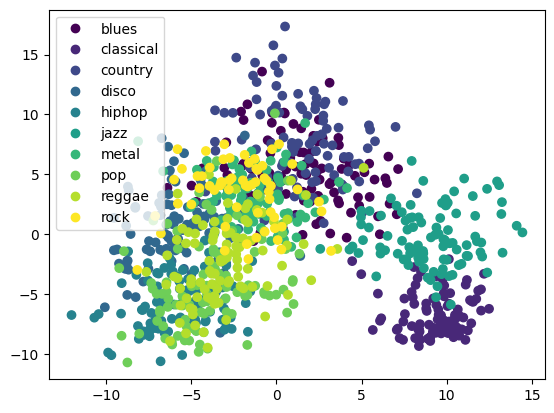

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# get the labels for each sample in the GTZAN dataset
labels = [dataset[i][1] for i in range(len(dataset) - 39)]
label_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# convert tensor to numpy array
representations_array = all_representations.cpu().numpy()

# perform PCA to reduce the dimensionality of the representations to 2
pca = PCA(n_components=2)
reduced_representations = pca.fit_transform(representations_array)

# create a scatter plot of the reduced representations with colors based on the labels
fig, ax = plt.subplots()
scatter = ax.scatter(reduced_representations[:, 0], reduced_representations[:, 1], c=labels)
handles, _ = scatter.legend_elements()
ax.legend(handles, label_names)

plt.show()

In [ ]:
print(pca.explained_variance_ratio_)

[0.22108996 0.19187006]


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import plotly.io as pio

# get the labels for each sample in the GTZAN dataset
labels = [dataset[i][1] for i in range(len(dataset) - 39)]
label_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# convert tensor to numpy array
representations_array = all_representations.cpu().numpy()

# perform PCA to reduce the dimensionality of the representations to 3
pca = PCA(n_components=3)
pca_features = pca.fit_transform(representations_array)

# create a 3D scatter plot
trace = go.Scatter3d(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    z=pca_features[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=labels,
        colorscale='Viridis',
        opacity=0.8
    )
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='PC1', showgrid=False, showbackground=False, showline=False, showticklabels=False),
        yaxis=dict(title='PC2', showgrid=False, showbackground=False, showline=False, showticklabels=False),
        zaxis=dict(title='PC3', showgrid=False, showbackground=False, showline=False, showticklabels=False)
    )
)

fig = go.Figure(data=[trace], layout=layout)
pio.show(fig)

In [ ]:
print(pca.explained_variance_ratio_)

[0.22109029 0.19187003 0.14292248]


In [ ]:
import numpy as np

# get the labels for each sample in the GTZAN dataset
labels = [dataset[i][1] for i in range(len(dataset) - 39)]
num_classes = 10

# initialize the centroids for each class
centroids = np.zeros((num_classes, representations_array.shape[1]))

# calculate the centroid for each class
for i in range(num_classes):
    # get the indices of the samples belonging to the class
    class_indices = np.where(np.array(labels) == i)[0]
    
    # calculate the mean of the representations of the class samples
    class_mean = np.mean(representations_array[class_indices], axis=0)
    
    # set the centroid for the class to the mean of the representations
    centroids[i] = class_mean

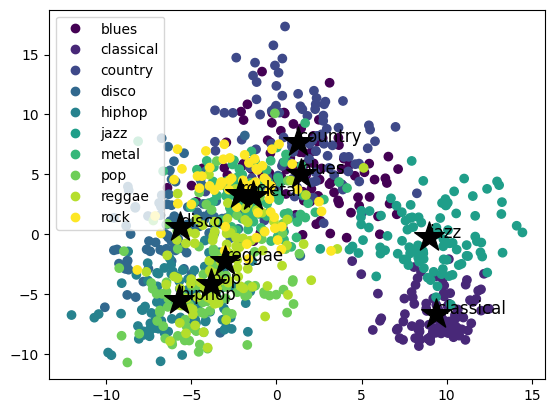

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# get the labels for each sample in the GTZAN dataset
labels = [dataset[i][1] for i in range(len(dataset) - 39)]
label_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# convert tensor to numpy array
representations_array = all_representations.cpu().numpy()

# perform PCA to reduce the dimensionality of the representations to 2
pca = PCA(n_components=2)
reduced_representations = pca.fit_transform(representations_array)

# calculate the PCA of the centroids
centroids_array = np.array(centroids)
pca_centroids = pca.transform(centroids_array)

# create a scatter plot of the reduced representations with colors based on the labels
fig, ax = plt.subplots()
scatter = ax.scatter(reduced_representations[:, 0], reduced_representations[:, 1], c=labels)
handles, _ = scatter.legend_elements()
ax.legend(handles, label_names)

# add the centroids as stars to the plot with genre labels
for i in range(len(pca_centroids)):
    ax.scatter(pca_centroids[i, 0], pca_centroids[i, 1], marker='*', s=500, c='black')
    ax.annotate(label_names[i], (pca_centroids[i, 0], pca_centroids[i, 1]), fontsize=12)

plt.show()


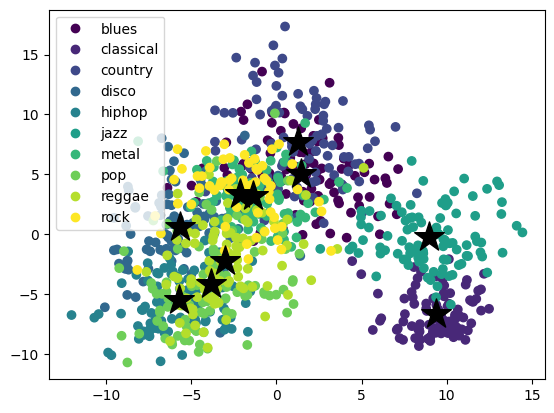

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# get the labels for each sample in the GTZAN dataset
labels = [dataset[i][1] for i in range(len(dataset) - 39)]
label_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# convert tensor to numpy array
representations_array = all_representations.cpu().numpy()

# perform PCA to reduce the dimensionality of the representations to 2
pca = PCA(n_components=2)
reduced_representations = pca.fit_transform(representations_array)

# calculate the PCA of the centroids
centroids_array = np.array(centroids)
pca_centroids = pca.transform(centroids_array)

# create a scatter plot of the reduced representations with colors based on the labels
fig, ax = plt.subplots()
scatter = ax.scatter(reduced_representations[:, 0], reduced_representations[:, 1], c=labels)
handles, _ = scatter.legend_elements()
ax.legend(handles, label_names)

# add the centroids as stars to the plot
ax.scatter(pca_centroids[:, 0], pca_centroids[:, 1], marker='*', s=500, c='black')

plt.show()

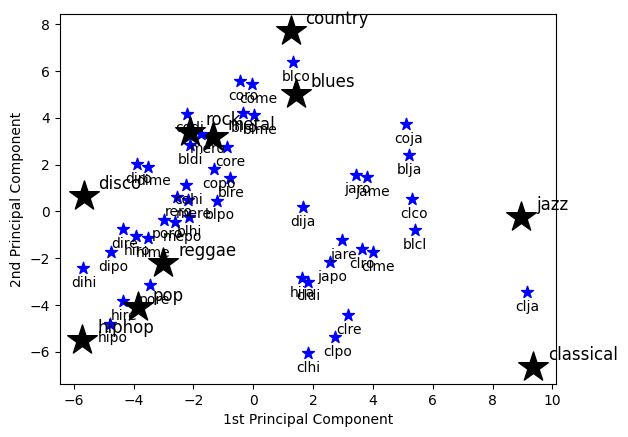

In [ ]:
# create a scatter plot of the reduced representations with colors based on the labels
fig, ax = plt.subplots()
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')

# add the centroids as stars to the plot with their labels
for i, label in enumerate(label_names):
    centroid = centroids_array[i]
    ax.scatter(pca_centroids[i, 0], pca_centroids[i, 1], marker='*', s=500, c='black')
    ax.text(pca_centroids[i, 0] + 0.5, pca_centroids[i, 1] + 0.3, label, fontsize=12)

    # calculate central points between each pair of centroids before PCA
    for j in range(i+1, len(label_names)):
        centroid2 = centroids_array[j]
        central_point = (centroid + centroid2) / 2
        
        # transform the central point using the already fitted PCA model
        pca_central_point = pca.transform([central_point])[0]
        label_name = label_names[i][:2] + label_names[j][:2] # concatenate the first two letters of each genre name
        ax.scatter(pca_central_point[0], pca_central_point[1], marker='*', s=80, c='blue')
        ax.text(pca_central_point[0] - 0.4, pca_central_point[1] - 0.8, label_name, fontsize=10)

plt.show()

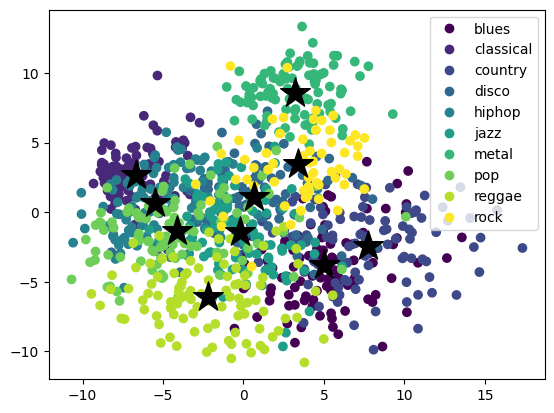

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# get the labels for each sample in the GTZAN dataset
labels = [dataset[i][1] for i in range(len(dataset) - 39)]
label_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# convert tensor to numpy array
representations_array = all_representations.cpu().numpy()

# perform PCA to reduce the dimensionality of the representations to 2
pca = PCA(n_components=3)
reduced_representations = pca.fit_transform(representations_array)

# calculate the PCA of the centroids
centroids_array = np.array(centroids)
pca_centroids = pca.transform(centroids_array)

# create a scatter plot of the reduced representations with colors based on the labels
fig, ax = plt.subplots()
scatter = ax.scatter(reduced_representations[:, 1], reduced_representations[:, 2], c=labels)
handles, _ = scatter.legend_elements()
ax.legend(handles, label_names)

# add the centroids as stars to the plot
ax.scatter(pca_centroids[:, 1], pca_centroids[:, 2], marker='*', s=500, c='black')

plt.show()

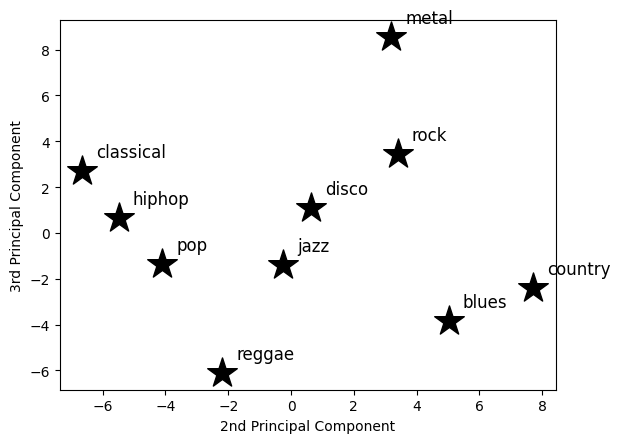

In [ ]:
# create a scatter plot of the reduced representations with colors based on the labels
fig, ax = plt.subplots()
ax.set_xlabel('2nd Principal Component')
ax.set_ylabel('3rd Principal Component')

# add the centroids as stars to the plot
ax.scatter(pca_centroids[:, 1], pca_centroids[:, 2], marker='*', s=500, c='black')
for i, label in enumerate(label_names):
    ax.annotate(label, (pca_centroids[i, 1], pca_centroids[i, 2]), xytext=(10, 10),
                textcoords='offset points', fontsize=12, color='black')

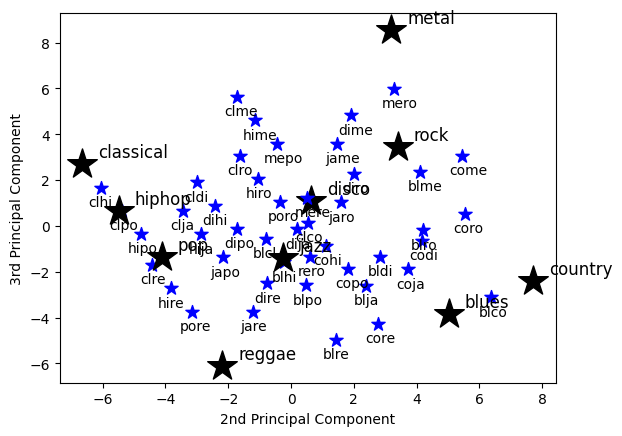

In [ ]:
# create a scatter plot of the reduced representations with colors based on the labels
fig, ax = plt.subplots()
ax.set_xlabel('2nd Principal Component')
ax.set_ylabel('3rd Principal Component')

# add the centroids as stars to the plot with their labels
for i, label in enumerate(label_names):
    centroid = centroids_array[i]
    ax.scatter(pca_centroids[i, 1], pca_centroids[i, 2], marker='*', s=500, c='black')
    ax.text(pca_centroids[i, 1] + 0.5, pca_centroids[i, 2] + 0.3, label, fontsize=12)

    # calculate central points between each pair of centroids before PCA
    for j in range(i+1, len(label_names)):
        centroid2 = centroids_array[j]
        central_point = (centroid + centroid2) / 2
        
        # transform the central point using the already fitted PCA model
        pca_central_point = pca.transform([central_point])[0]
        label_name = label_names[i][:2] + label_names[j][:2] # concatenate the first two letters of each genre name
        ax.scatter(pca_central_point[1], pca_central_point[2], marker='*', s=100, c='blue')
        ax.text(pca_central_point[1] - 0.4, pca_central_point[2] - 0.8, label_name, fontsize=10)

plt.show()